### Loads raw volumetric data in training format
* input volume -> NHWC
* output volume -> NHWC

In [4]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import helpers as H
from fastMRI.data import transforms as T

#Root directory of the project
ROOT_DIR = os.path.abspath(".")
TRAIN_DATASET_PATH = os.path.join(ROOT_DIR, "dataset")

# Dataset directories
LOW_DIR = "singlecoil_train_3D_images_48x/low/"
HIGH_DIR = "singlecoil_train_3D_images_48x/high/"

LOW_DIR_PATH = os.path.join(TRAIN_DATASET_PATH, LOW_DIR)
HIGH_DIR_PATH = os.path.join(TRAIN_DATASET_PATH, HIGH_DIR)
SAVE_DATA_PATH = os.path.join(TRAIN_DATASET_PATH, "singlecoil_train_3D_images_48x/")
LOW_DIR_PATH, HIGH_DIR_PATH

('/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/low/',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/high/')

In [5]:
w, h = 128, 128
def rs_img(img):
    '''W and H is 128 now
    '''
    print(img.shape[-1])
    print(type(img.shape[-1]))
    flatten = [cv2.resize(img[:,:,i], (w, h), interpolation=cv2.INTER_CUBIC) for i in range(img.shape[-1])]
    img = np.array(np.dstack(flatten)) 
    return img


def change_depth(img):

    img_start = img[:,:,:4]
    
    mid = int(img.shape[-1]/2)
    img_middle = img[:,:,mid-10:mid+10]
    
    img_end = img[:,:,-4:]
    img = np.concatenate((img_start, img_middle, img_end), axis=2)
    return img


def norm_vol(img):
    '''Normalize slices individually'''
    img_norm = []
    for i in img:
        i = H.normalize(i)
        img_norm.append(i)
        i=None
        
    img_norm = np.array(img_norm)
    img = None
    
    return img_norm

def show_slices(data, slice_nums, cmap=None):
    data = np.moveaxis(data, 2, 0)
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)        

#### Check number of contents

In [6]:
len(os.listdir(LOW_DIR_PATH)), len(os.listdir(HIGH_DIR_PATH))

(8, 8)

In [7]:
low_full_paths = ["{}/{}".format(LOW_DIR_PATH,l) for l in H.sort_paths(os.listdir(LOW_DIR_PATH))]
high_full_paths = ["{}/{}".format(HIGH_DIR_PATH,h) for h in H.sort_paths(os.listdir(HIGH_DIR_PATH))]

In [8]:
low_full_paths[:4]

['/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/low//1.npy',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/low//2.npy',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/low//3.npy',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/low//4.npy']

In [9]:
high_full_paths[:4]

['/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/high//1.npy',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/high//2.npy',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/high//3.npy',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/high//4.npy']

#### LOW MRI VOLUMES

In [10]:
x_train = []
c=0

for l in low_full_paths[:]:
    x = np.load("{}".format(l))
    x = np.moveaxis(x, 0, 2)
    
    # whole tensor normalized
    x = H.normalize(x)
    
    x = change_depth(x)
    
    x_train.append(x)
    c+=1
    #print(c, "----", l, x.shape)
    
    
x_train = np.array(x_train)
x_train.shape

(8, 320, 320, 28)

#### HIGH MRI VOLUMES

In [11]:
y_train = []
c=0

for h in high_full_paths[:]:
    y = np.load("{}".format(h))
    y = np.moveaxis(y, 0, 2)
    
    # whole tensor normalized
    y = H.normalize(y)
    
    y = change_depth(y)
    
    y_train.append(y)
    c+=1
    #print(c, "----", h, y.shape)
    
    
y_train = np.array(y_train)
y_train.shape

(8, 320, 320, 28)

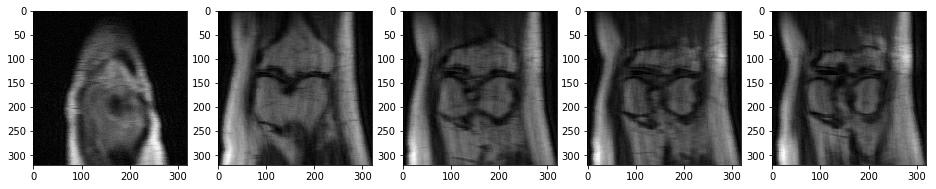

In [12]:
slice_num = [5, 16, 18, 19, 20]
n = 5
show_slices(x_train[n], slice_num, cmap='gray')

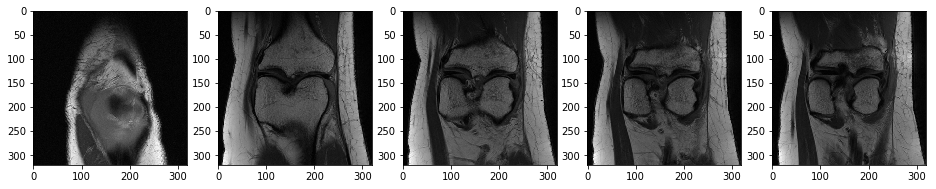

In [13]:
show_slices(y_train[n], slice_num, cmap='gray')

In [14]:
a = y_train[2]
print(a.shape)
a[1:2, 1:2]

(320, 320, 28)


array([[[0.04969891, 0.04633373, 0.04167083, 0.03682975, 0.03282655,
         0.03735039, 0.02616723, 0.03266038, 0.04154843, 0.02811437,
         0.03270372, 0.04320493, 0.04739183, 0.03379994, 0.01825734,
         0.02375833, 0.03198351, 0.02817412, 0.02571235, 0.0178226 ,
         0.04368317, 0.03222323, 0.02466904, 0.03020619, 0.02463632,
         0.03415789, 0.04983605, 0.03515473]]], dtype=float32)

4.4473354e-06 1.0


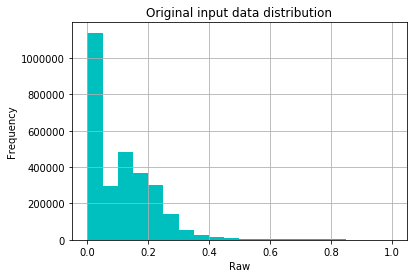

In [15]:
H.plot_hist(x_train[0])

0.0 0.9170858


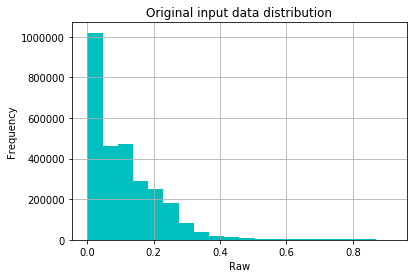

In [16]:
H.plot_hist(y_train[0])

In [18]:
min(a.flatten()), max(a.flatten())

(0.0, 1.0)

In [19]:
x_train.shape, y_train.shape

((8, 320, 320, 28), (8, 320, 320, 28))

In [20]:
SAVE_DATA_PATH

'/home/hasib/MRI-reconstruction/dataset/singlecoil_train_3D_images_48x/'

In [21]:
np.save("{}/x_train.npy".format(SAVE_DATA_PATH), x_train)
np.save("{}/y_train.npy".format(SAVE_DATA_PATH), y_train)

In [22]:
print("Done!")

Done!
